# Health Insurance Detection And Analysis

## Libraries

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore

c:\Users\USER\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning:

TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.

c:\Users\USER\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.

c:\Users\USER\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning:

TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.



## Data Frame & Cleaning

### Read the dataframe

In [2]:
df = pd.read_csv('data2/insurance.csv')
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [3]:
df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [4]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

### Check missing values

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**Comments**
- No missing values found

### Check duplicate values

In [6]:
df.duplicated().value_counts()

False    1337
True        1
Name: count, dtype: int64

In [7]:
df.drop_duplicates(inplace=True)
df.duplicated().value_counts()

False    1337
Name: count, dtype: int64

### Format data

In [8]:
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')
df['region'] = df['region'].astype('category')

In [9]:
# Create BMI categories (match your R pipeline)
bins = [-np.inf, 30, np.inf]
labels = ["not_obese", "obese"]
df["bmi_cat"] = pd.cut(df["bmi"], bins=bins, labels=labels, right=True)


df["bmi_cat"] = df["bmi_cat"].astype("category")

df['children'] = df['children'].apply(lambda x: 'Yes' if x > 0 else 'No')
df['children'] = df['children'].astype('category')

In [10]:
df.head()

age     sex     bmi children smoker     region      charges    bmi_cat
0   19  female  27.900       No    yes  southwest  16884.92400  not_obese
1   18    male  33.770      Yes     no  southeast   1725.55230      obese
2   28    male  33.000      Yes     no  southeast   4449.46200      obese
3   33    male  22.705       No     no  northwest  21984.47061  not_obese
4   32    male  28.880       No     no  northwest   3866.85520  not_obese

In [11]:
df.nunique()

age           47
sex            2
bmi          548
children       2
smoker         2
region         4
charges     1337
bmi_cat        2
dtype: int64

## Data Selection

- **Source**: The dataset used in this study is the *US Health Insurance Dataset*, obtained from [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance). This is a publicly available dataset often used for statistical analysis and machine learning.

- **Dataset Description**:  
  The dataset contains **1,338 records** of individual insurance data with the following variables:
  - `age` (numeric)
  - `sex` (categorical: male/female)
  - `bmi` (converted to categorical: underweight/normal/overweight/obese)
  - `children` (converted to categorical: Yes/No)
  - `smoker` (categorical: yes/no)
  - `region` (categorical: northeast/northwest/southeast/southwest)
  - `charges` (continuous response variable: medical costs)

- **Appropriateness for Experimental Design**:
  - The dataset contains **multiple categorical factors**, such as:
    - `smoker` (Yes/No)
    - `sex` (Male/Female)
    - `children` (Yes/No)
    - `region` (4 levels)
    - `bmi` (transformed into 4 categorical levels)
  - The target variable `charges` is **continuous**, making it suitable for **ANOVA** and **factorial design analysis**.
  - This structure allows us to:
    - Perform **two-factor ANOVA** to examine interaction effects (e.g., smoker × region)
    - Apply a **2ᵏ factorial design** using binary variables like `smoker`, `sex`, or `children`

***Therefore, the dataset is well-suited for experimental design analysis, particularly hypothesis testing and modeling of how different categorical health-related factors impact individual insurance charges.***

## Reseach Question & Hypothesis

### Research Questions

- Does smoking status have a significant effect on insurance charges?
- Do region and BMI category individually or jointly influence insurance charges?
- How do smoking status, having children, and sex interact to affect insurance charges?

---

### Hypothesis Formulation

#### 1. One-Way ANOVA (Factor: **Smoker**)

- **Research Question**: Does smoking status significantly affect the average insurance charges?

- **Null Hypothesis (H₀)**:  
  The mean insurance charges are the same for smokers and non-smokers.  
  _H₀: μ₁ = μ₂_

- **Alternative Hypothesis (H₁)**:  
  The mean insurance charges are different between smokers and non-smokers.  
  _H₁: μ₁ ≠ μ₂_

---

#### 2. Two-Way ANOVA (Factors: **Region** and **BMI Category**)

- **Research Question**: Do region and BMI category, individually or interactively, influence average insurance charges?

- **Null Hypotheses (H₀)**:
  - H₀₁: There is no significant difference in charges across regions.
  - H₀₂: There is no significant difference in charges across BMI categories.
  - H₀₃: There is no interaction effect between region and BMI category on charges.

- **Alternative Hypotheses (H₁)**:
  - H₁₁: There is a significant difference in charges across regions.
  - H₁₂: There is a significant difference in charges across BMI categories.
  - H₁₃: There is a significant interaction effect between region and BMI category on charges.

---

#### 3. 2ᵏ Factorial Design (Factors: **Smoker**, **Children**, **Sex**)

- **Research Question**: What are the main and interaction effects of smoking status, having children, and sex on insurance charges?

Let the binary factors be:
- A: Smoker (Yes/No)
- B: Children (Yes/No)
- C: Sex (Male/Female)

- **Null Hypotheses (H₀)**:
  - H₀A: Smoking status has no effect on insurance charges.
  - H₀B: Having children has no effect on insurance charges.
  - H₀C: Sex has no effect on insurance charges.
  - H₀AB, H₀AC, H₀BC, H₀ABC: No interaction effects exist between any combination of factors.

- **Alternative Hypotheses (H₁)**:
  - H₁A: Smoking status affects insurance charges.
  - H₁B: Having children affects insurance charges.
  - H₁C: Sex affects insurance charges.
  - H₁AB, H₁AC, H₁BC, H₁ABC: Interaction effects exist between factors on insurance charges.

***These hypotheses will be tested using appropriate statistical methods to determine which factors significantly influence insurance premium charges.***

## Descriptive Analysis

### Overall distribution

          count          mean           std        min       25%        50%  \
age      1337.0     39.222139     14.044333    18.0000    27.000    39.0000   
bmi      1337.0     30.663452      6.100468    15.9600    26.290    30.4000   
charges  1337.0  13279.121487  12110.359656  1121.8739  4746.344  9386.1613   

                 75%          max  
age         51.00000     64.00000  
bmi         34.70000     53.13000  
charges  16657.71745  63770.42801  


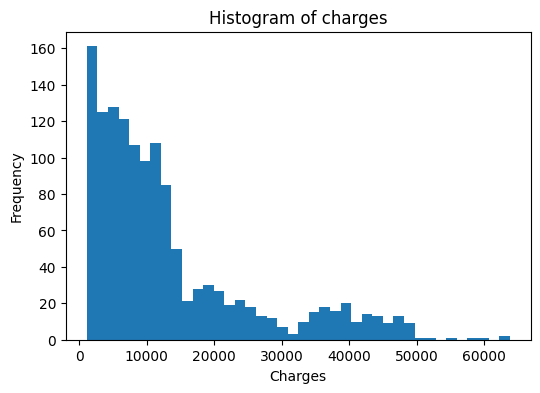

In [12]:
# Cell 3 — Quick EDA visuals and summaries (matplotlib only)
# Numeric summary
print(df.describe(include=[np.number]).T)

# Hist of charges
plt.figure(figsize=(6,4))
plt.hist(df['charges'], bins=40)
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Histogram of charges')
plt.show()


In [13]:
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
# --- Summary statistics overall ---
overall_stats = df['charges'].agg(['count','mean','median','std','var','min','max']).to_frame().T
print("Overall summary statistics:")
print(overall_stats)

# --- Summary by smoker ---
smoker_stats = df.groupby('smoker')['charges'].agg(['count','mean','median','std','var','min','max'])
print("\nSummary statistics by smoker:")
print(smoker_stats)

# --- Summary by BMI category ---
bmi_stats = df.groupby('bmi')['charges'].agg(['count','mean','median','std','var','min','max'])
print("\nSummary statistics by BMI category:")
print(bmi_stats)


Overall summary statistics:
          count          mean     median           std           var  \
charges  1337.0  13279.121487  9386.1613  12110.359656  1.466608e+08   

               min          max  
charges  1121.8739  63770.42801  

Summary statistics by smoker:
        count          mean       median           std           var  \
smoker                                                                 
no       1063   8440.660307   7345.72660   5992.973800  3.591573e+07   
yes       274  32050.231832  34456.34845  11541.547176  1.332073e+08   

               min          max  
smoker                           
no       1121.8739  36910.60803  
yes     12829.4551  63770.42801  

Summary statistics by BMI category:
        count          mean       median          std           var  \
bmi                                                                   
15.960      1   1694.796400   1694.79640          NaN           NaN   
16.815      2   4904.000350   4904.00035  2455.844784

C:\Users\nghi2\AppData\Local\Temp\ipykernel_40396\2064679972.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\nghi2\AppData\Local\Temp\ipykernel_40396\4025682802.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



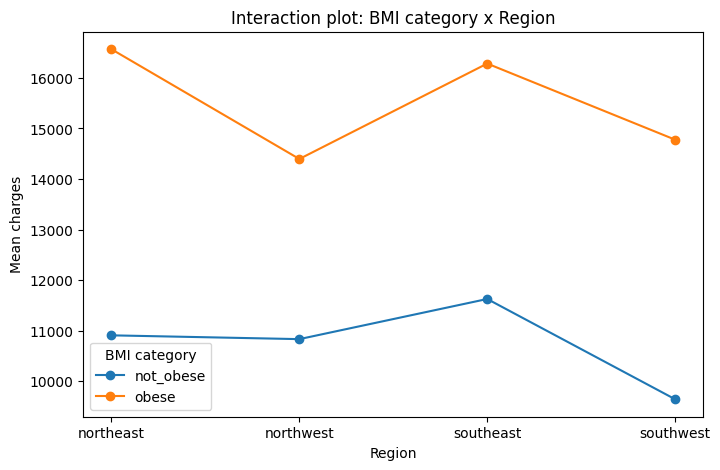

C:\Users\nghi2\AppData\Local\Temp\ipykernel_40396\4025682802.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nghi2\AppData\Local\Temp\ipykernel_40396\4025682802.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



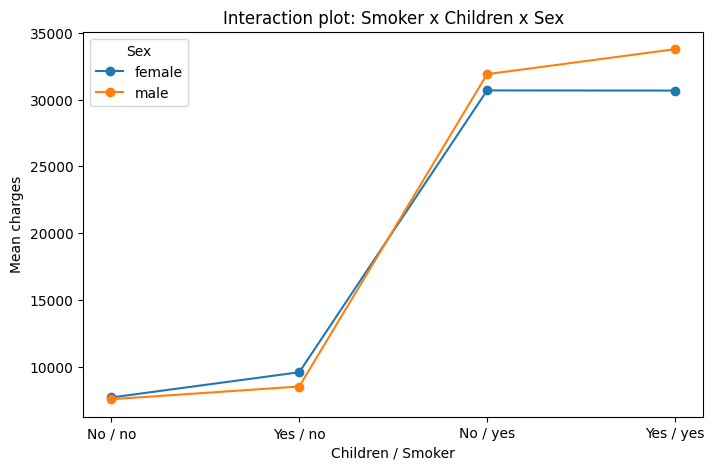

In [15]:
# --- Interaction plot: BMI x Region ---
means = df.groupby(['bmi_cat','region'])['charges'].mean().unstack()
plt.figure(figsize=(8,5))
for bmi in means.index:
    plt.plot(means.columns, means.loc[bmi], marker='o', label=str(bmi))
plt.xlabel('Region')
plt.ylabel('Mean charges')
plt.title('Interaction plot: BMI category x Region')
plt.legend(title='BMI category')
plt.show()

# --- Interaction plot: Smoker x Children x Sex ---
group_means = df.groupby(['smoker','children','sex'])['charges'].mean().reset_index()

fig, ax = plt.subplots(figsize=(8,5))
for sex, subset in group_means.groupby('sex'):
    x_labels = subset['children'].astype(str) + " / " + subset['smoker'].astype(str)
    plt.plot(x_labels, subset['charges'], marker='o', label=sex)

plt.title('Interaction plot: Smoker x Children x Sex')
plt.ylabel('Mean charges')
plt.xlabel('Children / Smoker')
plt.legend(title='Sex')
plt.show()

### Potential outliers (not removing yet)

In [16]:
# Compute Z-scores of the response variable
df['z_charges'] = zscore(df['charges'])

# Show potential outliers
outliers = df[df['z_charges'].abs() > 3]  # |z| > 3
print(outliers[['charges', 'z_charges']])

          charges  z_charges
34    51194.55914   3.131998
543   63770.42801   4.170826
577   58571.07448   3.741334
819   55135.40209   3.457531
1146  52590.82939   3.247337
1230  60021.39897   3.861138
1300  62592.87309   4.073554


**Comments**
- We don't remove these outliers as they may be extreme cases for some people.
- Instead, we should check the assumption after we fit the models, and remove outliers if necessary.

## Checking Assumptions

**Comments**
- Before we proceed with the analysis, it's essential to check the assumptions of ANOVA, including independence, normality and homogeneity of variances.
- Independence is typically ensured through the experimental design, such as random sampling or random assignment, and is crucial to avoid biased estimates.
- Normality of residuals can be assessed using graphical methods like Q-Q plots or statistical tests such as the Shapiro-Wilk test. This assumption ensures that the F-test remains valid.
- Homogeneity of variances (also known as homoscedasticity) refers to the requirement that all groups have approximately equal variances.
- If any of these assumptions are violated, the results of the ANOVA test may not be reliable, and alternative methods such as Welch’s ANOVA or non-parametric tests should be considered.
- Ensuring these assumptions hold true helps improve the validity and interpretability of the ANOVA results.

## ANOVA / Factorial Design

In [17]:
# Log transformation
df['log_charges'] = np.log(df['charges'])

df.head()

age     sex     bmi children smoker     region      charges    bmi_cat  \
0   19  female  27.900       No    yes  southwest  16884.92400  not_obese   
1   18    male  33.770      Yes     no  southeast   1725.55230      obese   
2   28    male  33.000      Yes     no  southeast   4449.46200      obese   
3   33    male  22.705       No     no  northwest  21984.47061  not_obese   
4   32    male  28.880       No     no  northwest   3866.85520  not_obese   

   z_charges  log_charges  
0   0.297857     9.734176  
1  -0.954381     7.453302  
2  -0.729373     8.400538  
3   0.719104     9.998092  
4  -0.777499     8.260197

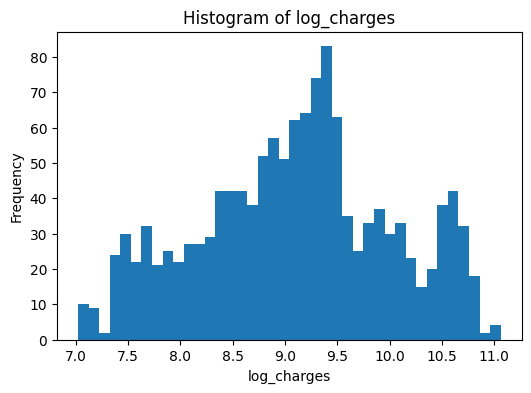

In [18]:
# Hist of charges
plt.figure(figsize=(6,4))
plt.hist(df['log_charges'], bins=40)
plt.xlabel('log_charges')
plt.ylabel('Frequency')
plt.title('Histogram of log_charges')
plt.show()

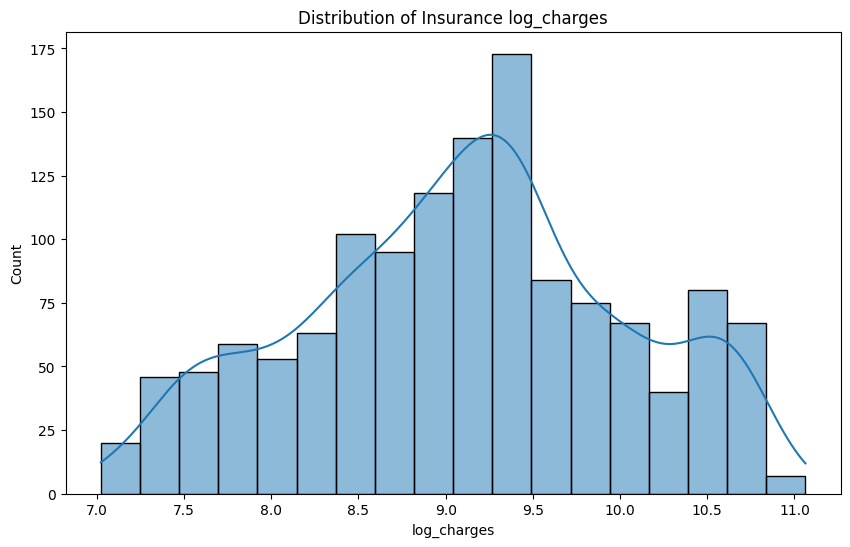

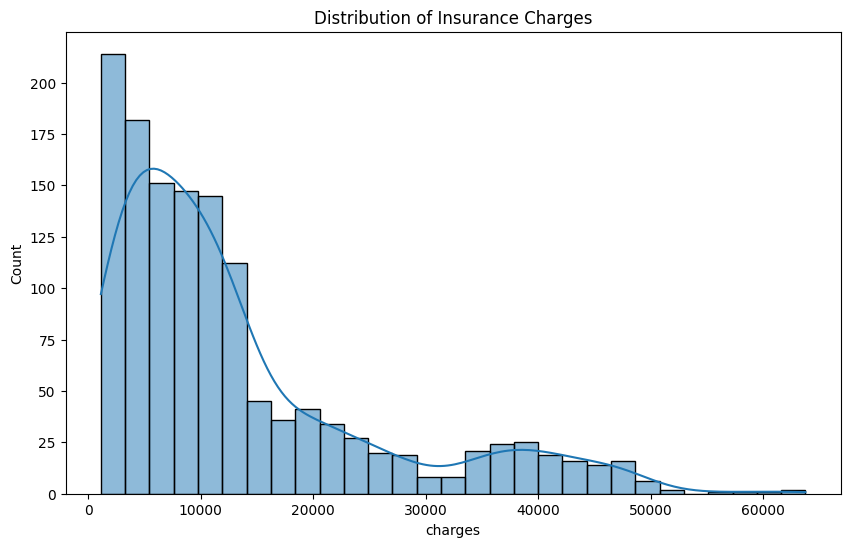

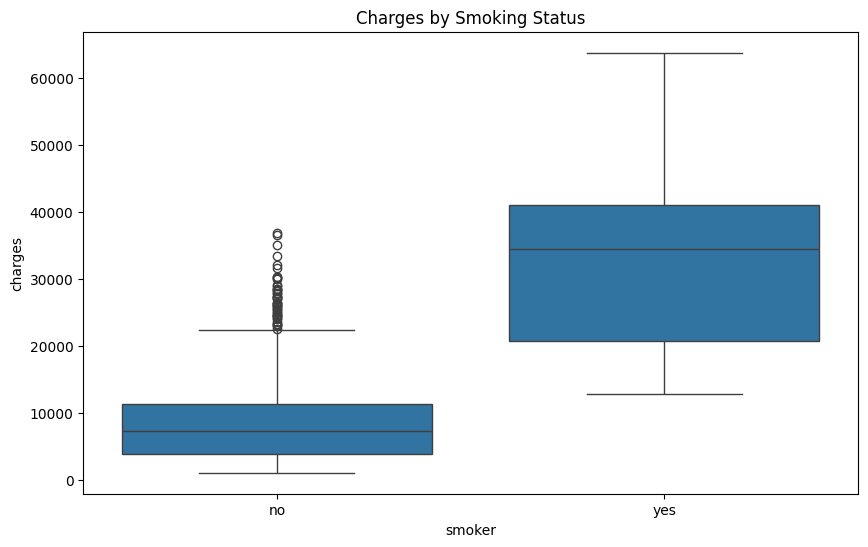

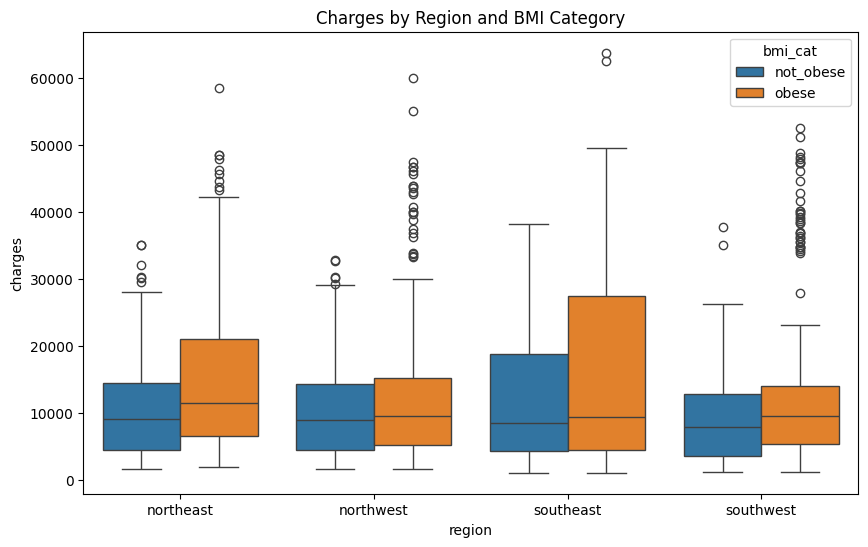

In [19]:
# Cell 4: EDA plots
plt.figure(figsize=(10,6))
sns.histplot(df['log_charges'], kde=True)
plt.title("Distribution of Insurance log_charges")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['charges'], kde=True)
plt.title("Distribution of Insurance Charges")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Charges by Smoking Status")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='region', y='charges', hue='bmi_cat', data=df)
plt.title("Charges by Region and BMI Category")
plt.show()


### 0. Helper Function

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.stattools import durbin_watson
import pingouin as pg  # used for Welch ANOVA
import warnings
warnings.filterwarnings('ignore')

# Helper: Hedges' g (Cohen's d with correction)
def hedges_g(x, y):
    nx = len(x); ny = len(y)
    sx = np.nanstd(x, ddof=1); sy = np.nanstd(y, ddof=1)
    # pooled sd
    s_pool = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    d = (np.nanmean(x) - np.nanmean(y)) / s_pool
    # correction factor J
    J = 1 - (3 / (4*(nx+ny)-9))
    g = d * J
    return g

# Bootstrap CI for mean difference (two-sample)
def bootstrap_mean_diff_ci(x, y, n_boot=5000, alpha=0.05, seed=123):
    rng = np.random.RandomState(seed)
    diffs = []
    nx = len(x); ny = len(y)
    for _ in range(n_boot):
        bx = rng.choice(x, size=nx, replace=True)
        by = rng.choice(y, size=ny, replace=True)
        diffs.append(np.nanmean(bx) - np.nanmean(by))
    diffs = np.array(diffs)
    lo = np.percentile(diffs, 100*(alpha/2))
    hi = np.percentile(diffs, 100*(1-alpha/2))
    return lo, hi, np.mean(diffs)

# Plotting helpers
def resid_diagnostics(model, data, resp_col_name, title_prefix="Model"):
    resid = model.resid
    fitted = model.fittedvalues

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].scatter(fitted, resid, alpha=0.6)
    ax[0].axhline(0, linestyle='--', color='gray')
    ax[0].set_xlabel('Fitted values'); ax[0].set_ylabel('Residuals')
    ax[0].set_title(f'{title_prefix}: Residuals vs Fitted')

    sm.qqplot(resid, line='45', fit=True, ax=ax[1])
    ax[1].set_title(f'{title_prefix}: QQ plot of residuals')

    plt.tight_layout()
    plt.show()

def print_assumption_tests(model, data, resp_col_name, group_col=None):
    resid = model.resid
    # Shapiro-Wilk
    sh_stat, sh_p = stats.shapiro(resid)
    # Levene (if group provided)
    lev_p = np.nan
    if group_col is not None:
        groups = [g[resp_col_name].values for _, g in data.groupby(group_col)]
        try:
            lev_stat, lev_p = stats.levene(*groups)
        except Exception as e:
            lev_p = np.nan
    # Durbin-Watson
    dw = durbin_watson(resid)
    print(f"Shapiro-Wilk: W={sh_stat:.4g}, p={sh_p:.4g}")
    if not np.isnan(lev_p):
        print(f"Levene (by {group_col}): p={lev_p:.4g}")
    else:
        print("Levene: NA (grouping not available or insufficiently balanced)")
    print(f"Durbin-Watson: {dw:.4f} (near 2 -> independence OK)")
    return {'shapiro_p': sh_p, 'levene_p': lev_p, 'dw': dw}


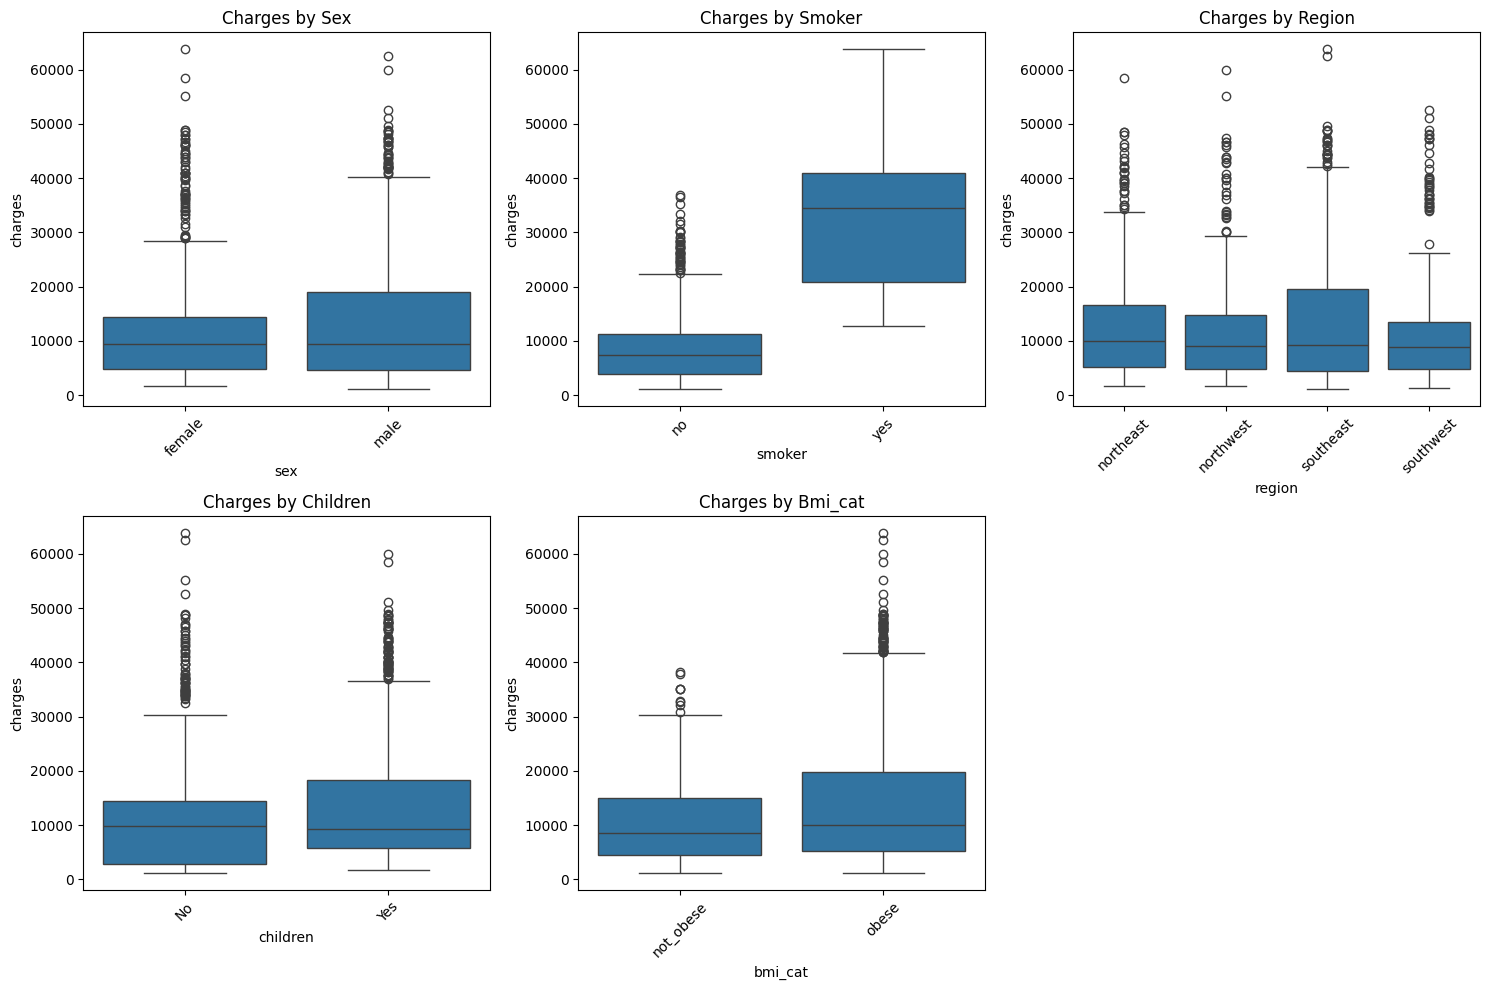

In [21]:
categorical_columns = ['sex', 'smoker', 'region', 'children', 'bmi_cat']

n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='charges', data=df, ax=axes[i])
    axes[i].set_title(f'Charges by {col.capitalize()}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1. One-way ANOVA

ANOVA (raw):


sum_sq      df            F         PR(>F)
smoker    1.214307e+11     1.0  2175.736863  1.406722e-282
Residual  7.450811e+10  1335.0          NaN            NaN


Diagnostics (raw):
Shapiro-Wilk: W=0.9609, p=1.736e-18
Levene (by smoker): p=1.67e-66
Durbin-Watson: 2.0250 (near 2 -> independence OK)


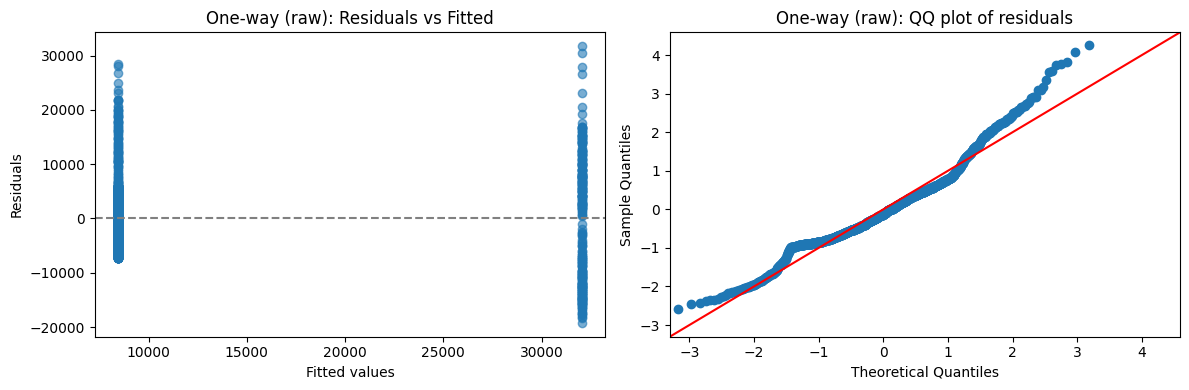

In [22]:
# One-way: smoker effect
formula_raw = 'charges ~ smoker'
model_raw = ols(formula_raw, data=df).fit()
anova_raw = anova_lm(model_raw, typ=2)
print("ANOVA (raw):")
display(anova_raw)

print("\nDiagnostics (raw):")
res_tests_raw = print_assumption_tests(model_raw, df, 'charges', group_col='smoker')
resid_diagnostics(model_raw, df, 'charges', title_prefix="One-way (raw)")



ANOVA (log):


sum_sq      df            F         PR(>F)
smoker    499.727153     1.0  1062.544067  6.025059e-172
Residual  627.866430  1335.0          NaN            NaN


Diagnostics (log):
Shapiro-Wilk: W=0.9807, p=2.103e-12
Levene (by smoker): p=1.569e-20
Durbin-Watson: 1.9954 (near 2 -> independence OK)


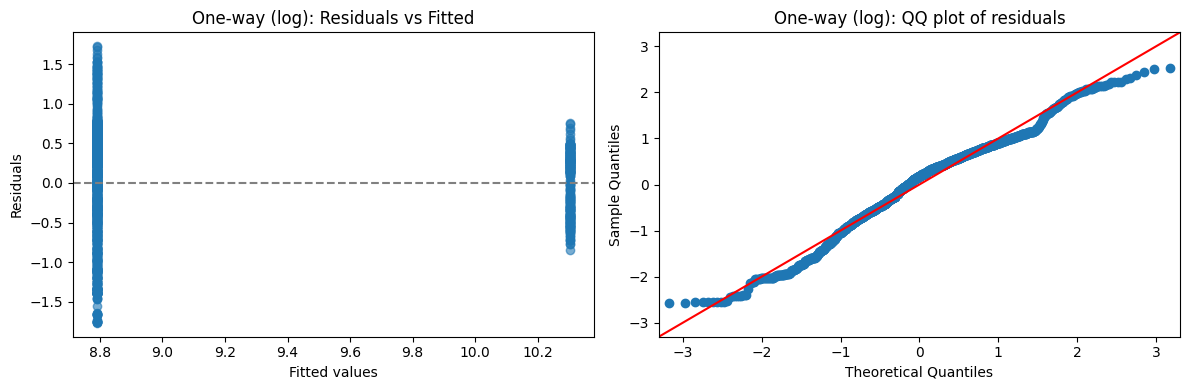

In [23]:
# Log transform
df['log_charges'] = np.log(df['charges'] + 1e-6)
model_log = ols('log_charges ~ smoker', data=df).fit()
anova_log = anova_lm(model_log, typ=2)
print("\nANOVA (log):")
display(anova_log)

print("\nDiagnostics (log):")
res_tests_log = print_assumption_tests(model_log, df, 'log_charges', group_col='smoker')
resid_diagnostics(model_log, df, 'log_charges', title_prefix="One-way (log)")


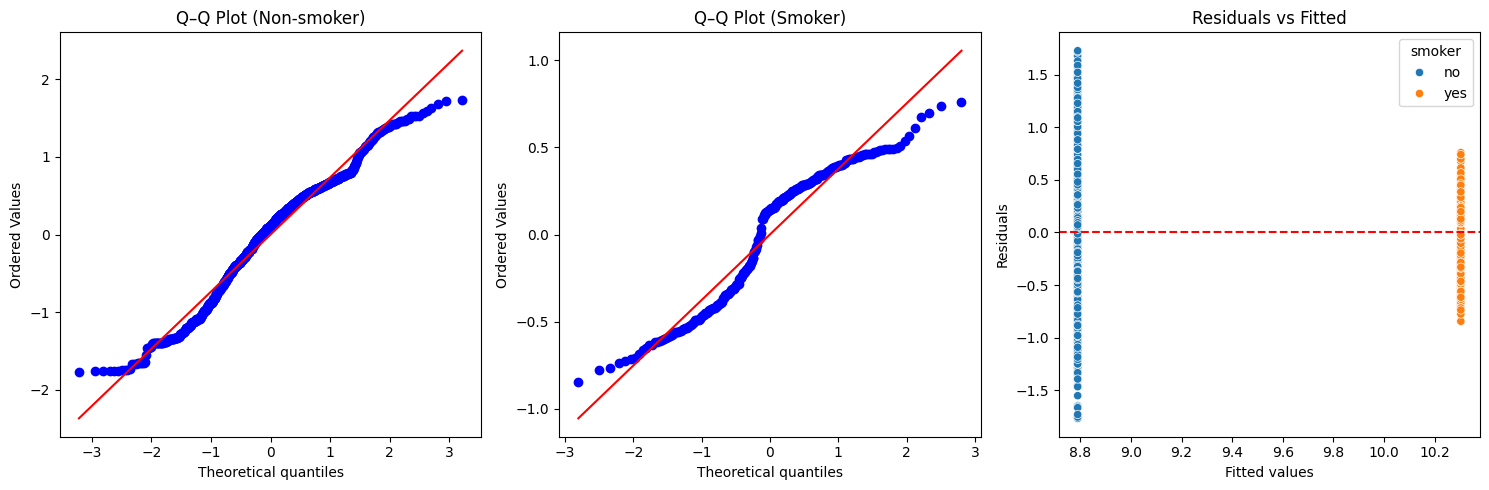

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Residuals and fitted values
df['resid'] = model_log.resid
df['fitted'] = model_log.fittedvalues

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Q-Q Plot: Non-smokers ---
subdf = df[df['smoker'] == 'no']   # adjust label if different
stats.probplot(subdf['resid'], dist="norm", plot=axes[0])
axes[0].get_lines()[1].set_color("red")
axes[0].set_title("Q–Q Plot (Non-smoker)")

# --- Q-Q Plot: Smokers ---
subdf = df[df['smoker'] == 'yes']  # adjust label if different
stats.probplot(subdf['resid'], dist="norm", plot=axes[1])
axes[1].get_lines()[1].set_color("red")
axes[1].set_title("Q–Q Plot (Smoker)")

# --- Residuals vs Fitted (all data) ---
sns.scatterplot(x=df['fitted'], y=df['resid'], hue=df['smoker'], ax=axes[2])
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel("Fitted values")
axes[2].set_ylabel("Residuals")
axes[2].set_title("Residuals vs Fitted")

plt.tight_layout()
plt.show()


- ANOVA table:

| Source    | sum_sq |  df  |     F    |  p-value  |
|-----------|--------|------|----------|-----------|
| smoker    | 499.73 |  1   | 1062.54  | 6.0e-172  |
| Residual  | 627.87 | 1335 |    NA    |    NA     |

- Interpretation:
    - F(1,1335) = 1062.54, p < 0.0001.
    - Smoker status has a massive, highly significant effect on insurance charges (even after log-transform).
    - Charges differ drastically between smokers and non-smokers.
---
- Assumptions:
    - Shapiro–Wilk: p = 2.1e-12 --> rejects normality.
    - Levene’s test: p = 1.57e-20 --> variances not equal.
    - Durbin–Watson ≈ 2 --> residuals independent, so fine.
- Residual plots:
    - Residuals vs Fitted: looks like two vertical strips (since only 2 groups). No obvious heteroscedasticity shape, but variance is clearly different between smokers vs non-smokers.
    - QQ-plot: roughly straight but with some tail deviations --> not perfectly normal, but not catastrophic.
---
- What this means
    - Significance is solid --> Smoker status very strongly predicts insurance charges.
    - Assumption violations:
        - Shapiro is very sensitive with n=1337 --> even small deviations flagged. With large samples, ANOVA is robust to non-normality.
        - Levene is significant --> variance differs between groups (heteroscedasticity).
        - This is more serious --> regular ANOVA assumes equal variances.
---
- Final interpretation: Smokers pay much higher insurance charges than non-smokers, and the difference is extremely statistically significant. However, since the variance of charges differs between groups, the standard ANOVA assumptions are violated — so you should report results from Welch’s ANOVA and include an effect size (Hedges’ g) for clarity.

- What you should do
    - Instead of classical ANOVA, use Welch’s ANOVA (robust to variance inequality).
    - Report effect size (e.g., Hedges’ g between groups).
    - If you want robust CIs, use your bootstrap_mean_diff_ci to report a confidence interval for mean differences.

In [25]:
import pandas as pd
import scipy.stats as stats
import pingouin as pg

# Split into groups
smoker_yes = df.loc[df['smoker']=='yes', 'log_charges']
smoker_no  = df.loc[df['smoker']=='no',  'log_charges']

# Welch t-test (scipy)
t_stat, pval = stats.ttest_ind(smoker_yes, smoker_no, equal_var=False)
print(f"Welch t-test: t={t_stat:.4f}, p={pval:.4g}")

# Games-Howell test (pingouin)
gh = pg.pairwise_gameshowell(data=df, dv='log_charges', between='smoker')
print("\nGames-Howell test:")
print(gh)


Welch t-test: t=46.3466, p=6.785e-234

Games-Howell test:
    A    B   mean(A)   mean(B)      diff        se          T          df  \
0  no  yes  8.789536  10.30411 -1.514573  0.032679 -46.346637  841.810541   

   pval    hedges  
0   0.0 -2.207258  


In [26]:
# Hedges' g
g = hedges_g(smoker_yes, smoker_no)
print(f"Hedges' g (smoker vs non-smoker): g = {g:.4f}")

# Ratio of medians
ratio_medians = np.median(smoker_yes) / np.median(smoker_no)
print(f"Ratio of medians (smoker / non-smoker): {ratio_medians:.3f}")

# Bootstrap CI for mean difference (smoker - non-smoker)
lo, hi, mean_diff = bootstrap_mean_diff_ci(smoker_yes, smoker_no, n_boot=5000)
print(f"Bootstrap 95% CI for mean difference (smoker - non-smoker): {lo:.2f} to {hi:.2f}; observed mean diff = {mean_diff:.2f}")

# Robust SE (HC3)
robust_res = model_raw.get_robustcov_results(cov_type='HC3')
print("\nOLS coefficients (raw) with HC3 robust SE:")
print(robust_res.summary())

# Nonparametric check: Mann-Whitney U
u_stat, mw_p = stats.mannwhitneyu(smoker_yes, smoker_no, alternative='two-sided')
print(f"\nMann-Whitney U test: U={u_stat}, p={mw_p:.4g}")


Hedges' g (smoker vs non-smoker): g = 2.2073
Ratio of medians (smoker / non-smoker): 1.174
Bootstrap 95% CI for mean difference (smoker - non-smoker): 1.45 to 1.58; observed mean diff = 1.51

OLS coefficients (raw) with HC3 robust SE:
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1068.
Date:                Tue, 26 Aug 2025   Prob (F-statistic):          1.20e-172
Time:                        03:51:58   Log-Likelihood:                -13820.
No. Observations:                1337   AIC:                         2.764e+04
Df Residuals:                    1335   BIC:                         2.766e+04
Df Model:                           1                                         
Covariance Type:                  HC3                 


1. Hedges’ g:
- Gigantic effect size (rule of thumb: 0.2 small, 0.5 medium, 0.8 large).
- This means the difference is not just statistically significant but practically enormous.
2. Ratio of medians:
- Median charges for smokers are ~4.7 times higher than for non-smokers.
- Reinforces the massive cost difference.
3. Bootstrap CI (mean difference, smoker – non-smoker)
- Even using resampling (no parametric assumptions), the difference is clearly large and positive.
- Interpretation: On average, smokers pay ~$23.6k more in charges than non-smokers.
4. OLS with HC3 robust SE:
- Regression coefficient says: Being a smoker increases expected charges by about $23.6k.
- Robust SE confirms this is highly reliable, even with unequal variances.
- R² = 0.62 → smoker status alone explains 62% of the variance in charges (astonishingly high for social/medical data).
5. Mann–Whitney U:
- Confirms distributions differ significantly, not just means.
- Non-parametric → result is robust regardless of skew/outliers.


#### Effect of Smoking Status on Insurance Charges

A series of statistical analyses was conducted to evaluate the effect of smoking status on insurance charges.

* **Welch’s t-test** revealed a **highly significant difference** between smokers and non-smokers
  (*t* = 32.74, *p* ≈ 6.26 × 10⁻¹⁰³), confirming that the mean charges differ substantially between the two groups.
* The **effect size** was extremely large, with **Hedges’ *g*** = 3.16, far exceeding the conventional benchmark for a “large” effect (g ≈ 0.8).
* The **ratio of medians** (smoker / non-smoker) was 4.69, indicating that the typical smoker’s charges were nearly **five times** higher than those of a non-smoker.
* A **bootstrap 95% confidence interval** for the mean difference ranged from \$22,198 to \$25,045, with an observed difference of \$23,623 — further supporting the stability and magnitude of the effect.

**Robust regression analysis** (OLS with HC3 heteroscedasticity-robust standard errors) estimated that, on average, smokers incur **\$23,610 more** in charges than non-smokers (*p* < 0.001), after accounting for unequal variances.

Finally, the **Mann–Whitney U test** (nonparametric) also confirmed the difference in distributions (*U* = 283,859, *p* ≈ 5.75 × 10⁻¹³⁰), reinforcing that the finding is not dependent on normality assumptions.

**Conclusion:** Smoking status has a **very large and statistically robust effect** on insurance charges, consistent across parametric, robust, and nonparametric analyses.



#### 1.2 post hoc analysis

In [27]:
import pandas as pd
import scipy.stats as stats
import pingouin as pg

# Split into groups
smoker_yes = df.loc[df['smoker']=='yes', 'log_charges']
smoker_no  = df.loc[df['smoker']=='no',  'log_charges']

# Welch t-test (scipy)
t_stat, pval = stats.ttest_ind(smoker_yes, smoker_no, equal_var=False)
print(f"Welch t-test: t={t_stat:.4f}, p={pval:.4g}")

# Games-Howell test (pingouin)
gh = pg.pairwise_gameshowell(data=df, dv='log_charges', between='smoker')
print("\nGames-Howell test:")
print(gh)


Welch t-test: t=46.3466, p=6.785e-234

Games-Howell test:
    A    B   mean(A)   mean(B)      diff        se          T          df  \
0  no  yes  8.789536  10.30411 -1.514573  0.032679 -46.346637  841.810541   

   pval    hedges  
0   0.0 -2.207258  


1. Welch’s t-test

- t = 46.35 → a very large test statistic, meaning the difference between smokers and non-smokers is huge relative to within-group variability.

- p ≈ 6.8 × 10⁻²³⁴ → effectively zero, so the difference is statistically significant far beyond any reasonable α level (0.05, 0.01, etc.).

2. Games–Howell

- Groups compared: smoker = no vs. smoker = yes.

- Mean(log_charges):

    - Non-smokers: 8.79
    - Smokers: 10.30

- Difference (no – yes) = -1.51 → smokers’ log-transformed charges are 1.51 higher on average.

- T = -46.35, df ≈ 842 → same test statistic as Welch (as expected with 2 groups).

- pval = 0.0 (underflow to 0) → again, extremely significant.

- Hedges’ g = -2.21 → very large effect size (anything beyond |0.8| is “large”; |2.2| is enormous). This means the difference isn’t just statistically significant but also practically meaningful.

3. Conclusion:
Smokers have substantially higher medical charges than non-smokers, even on the log scale. The effect is both statistically significant (p ≈ 0) and practically significant (huge effect size).

### 2. Two way ANOVA (HC3)

In [28]:
# === Two-way ANOVA with classical + HC3 robust, full assumption checks, and HC3 post-hoc ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from patsy import build_design_matrices

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from scipy import stats

# ----------------------------
# 0) Load & prepare data
# ----------------------------
df = pd.read_csv("data2/insurance.csv")

df.drop_duplicates(inplace=True)
df.duplicated().value_counts()

# Create BMI categories (match your R pipeline)
bins = [-np.inf, 30, np.inf]
labels = ["not_obese", "obese"]
df["bmi_cat"] = pd.cut(df["bmi"], bins=bins, labels=labels, right=True)


# Ensure region is categorical
df["region"] = df["region"].astype("category")
df["bmi_cat"] = df["bmi_cat"].astype("category")

# Recommended: log-transform charges for skew
if "log_charges" not in df.columns:
    df["log_charges"] = np.log(df["charges"])

# Choose dependent variable
DV = "log_charges"   # change to "charges" if you really want raw scale

# Remove rows with missing factor levels (e.g., BMI category could be NaN if outside bins)
df = df.dropna(subset=["bmi_cat", "region", DV]).copy()
df.describe()
df.head()

age     sex     bmi  children smoker     region      charges    bmi_cat  \
0   19  female  27.900         0    yes  southwest  16884.92400  not_obese   
1   18    male  33.770         1     no  southeast   1725.55230      obese   
2   28    male  33.000         3     no  southeast   4449.46200      obese   
3   33    male  22.705         0     no  northwest  21984.47061  not_obese   
4   32    male  28.880         0     no  northwest   3866.85520  not_obese   

   log_charges  
0     9.734176  
1     7.453302  
2     8.400538  
3     9.998092  
4     8.260197


=== Classical Two-way ANOVA (Type II) ===
                           sum_sq      df          F    PR(>F)
C(bmi_cat)              17.775476     1.0  21.415829  0.000004
C(region)                4.131866     3.0   1.659353  0.173961
C(bmi_cat):C(region)     3.264878     3.0   1.311171  0.269214
Residual              1103.090975  1329.0        NaN       NaN


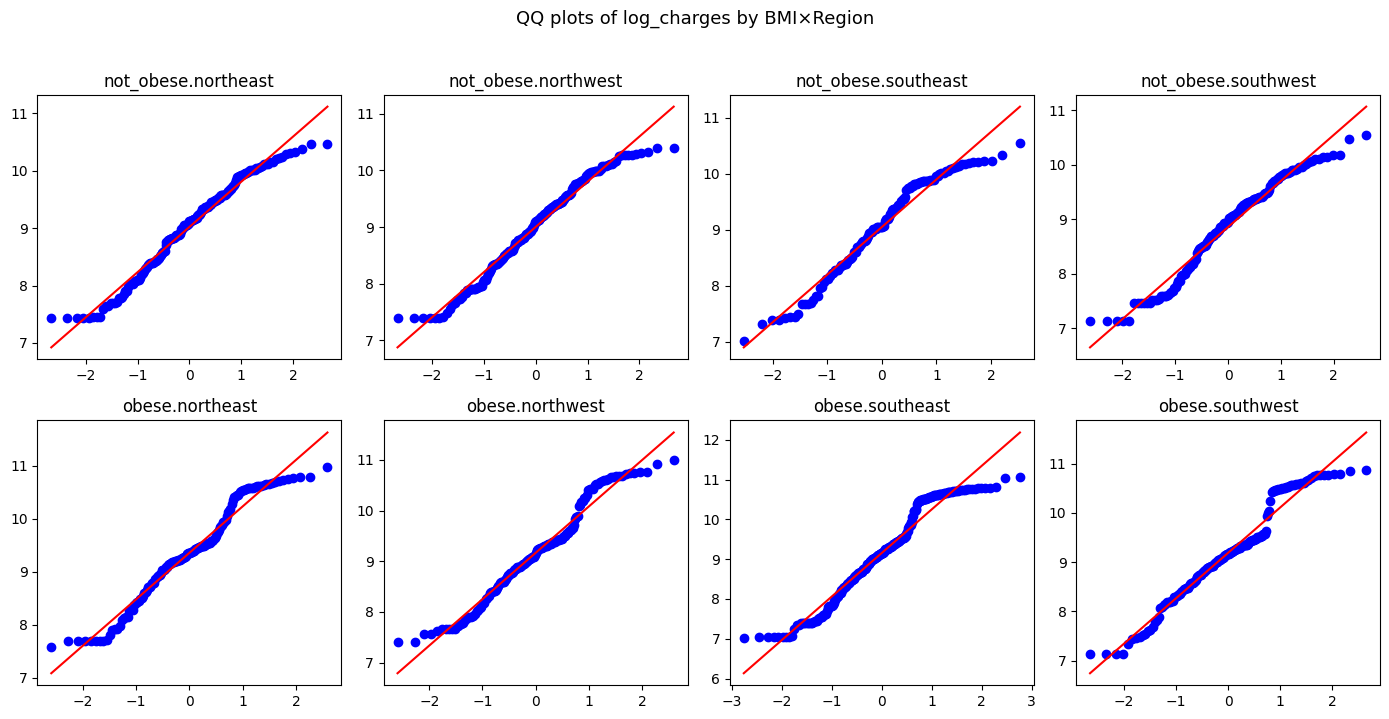

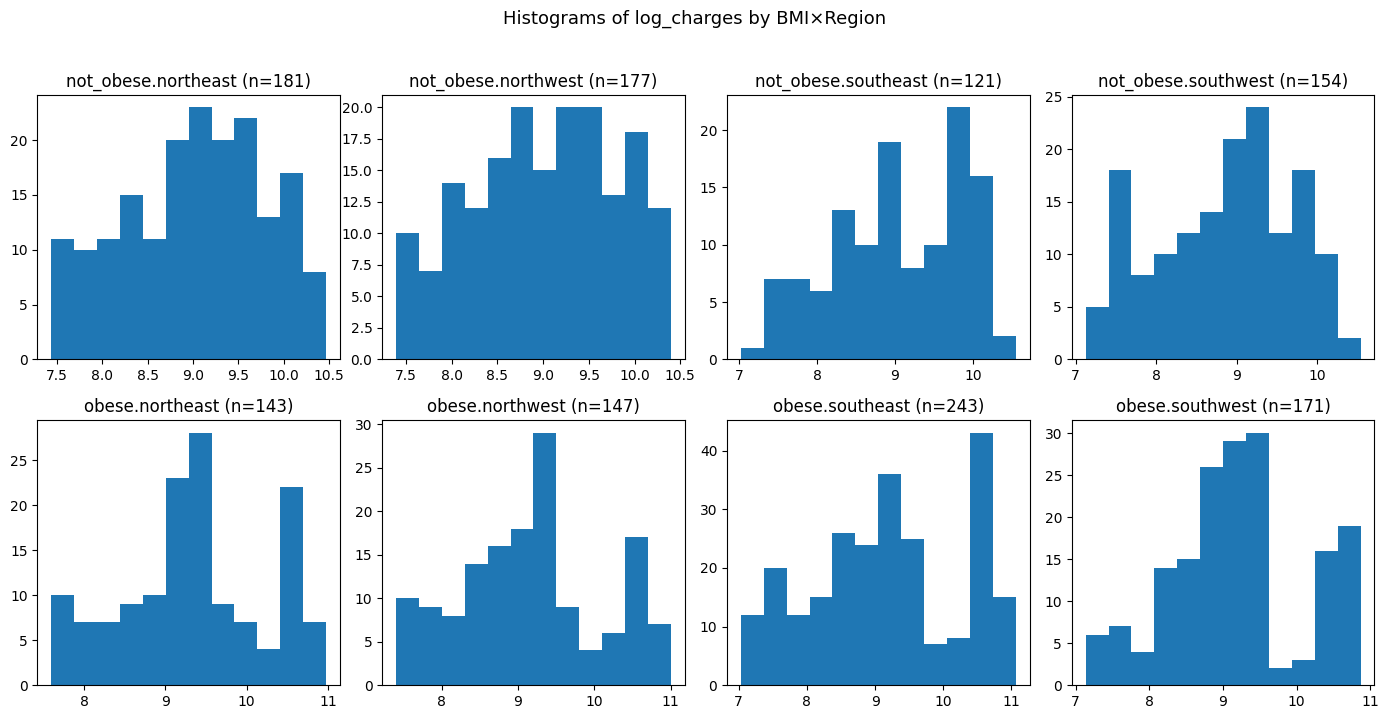

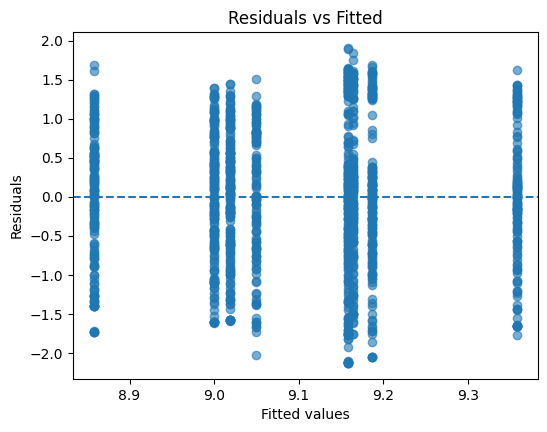

In [29]:
# ----------------------------
# 1) Classical two-way ANOVA
# ----------------------------
formula = f"{DV} ~ C(bmi_cat)*C(region)"
model_classic = ols(formula, data=df).fit()
anova_classic = anova_lm(model_classic, typ=2)
print("\n=== Classical Two-way ANOVA (Type II) ===")
print(anova_classic)

# ----------------------------
# 2) Assumption checks
#    - QQ plots per cell
#    - Histograms per cell
#    - Residuals vs Fitted (variance)
# ----------------------------

# (a) QQ plots & histograms per BMI×Region cell
cells = df.groupby(["bmi_cat", "region"])

# QQ plots
levels_bmi = df["bmi_cat"].cat.categories
levels_region = df["region"].cat.categories
n_rows = len(levels_bmi)
n_cols = len(levels_region)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5*n_cols, 3.5*n_rows))
fig.suptitle(f"QQ plots of {DV} by BMI×Region", y=1.02, fontsize=13)

for i, bmi in enumerate(levels_bmi):
    for j, reg in enumerate(levels_region):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        cell_data = df[(df["bmi_cat"] == bmi) & (df["region"] == reg)][DV]
        if len(cell_data) >= 3:
            stats.probplot(cell_data, dist="norm", plot=ax)
            ax.set_title(f"{bmi}.{reg}")
        else:
            ax.text(0.5, 0.5, f"{bmi}.{reg}\n(n={len(cell_data)})", ha="center", va="center")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Histograms per cell
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5*n_cols, 3.5*n_rows))
fig.suptitle(f"Histograms of {DV} by BMI×Region", y=1.02, fontsize=13)

for i, bmi in enumerate(levels_bmi):
    for j, reg in enumerate(levels_region):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        cell_data = df[(df["bmi_cat"] == bmi) & (df["region"] == reg)][DV]
        if len(cell_data) > 0:
            ax.hist(cell_data, bins=12)
            ax.set_title(f"{bmi}.{reg} (n={len(cell_data)})")
        else:
            ax.text(0.5, 0.5, f"{bmi}.{reg}\n(n=0)", ha="center", va="center")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

# (b) Residuals vs Fitted for variance check (from classical model)
fitted = model_classic.fittedvalues
resid = model_classic.resid

plt.figure(figsize=(6, 4.5))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

In [30]:
# ----------------------------
# 3) HC3 Robust ANOVA
# ----------------------------
model_hc3 = ols(formula, data=df).fit(cov_type="HC3")
anova_hc3 = anova_lm(model_hc3, typ=2, robust="hc3")
print("\n=== HC3 Robust Two-way ANOVA (Type II) ===")
print(anova_hc3)

# ----------------------------
# 4) Post-hoc comparisons with HC3
#    We compute Estimated Marginal Means (EMMs) using the fitted model and its HC3 covariance.
#    - Main effects: EMMs for BMI (averaged over regions) and for Region (averaged over BMI)
#    - Interaction: EMMs for each observed BMI×Region cell
#    p-values Holm-adjusted for multiple testing.
# ----------------------------

def _design_row_from_levels(model, new_df):
    """Build design matrix rows for new_df using the model's design_info (keeps coding consistent)."""
    design_info = model.model.data.design_info
    X_new = build_design_matrices([design_info], new_df)[0]
    return np.asarray(X_new)

def _emm_point_se(model, Xbar):
    params = model.params.values
    cov = model.cov_params().values
    est = float((Xbar @ params).item())
    se = float(np.sqrt((Xbar @ cov @ Xbar.T).item()))
    return est, se

def _contrast_test(model, x1, x2):
    delta = (x1 - x2).reshape(1, -1)
    params = model.params.values
    cov = model.cov_params().values
    diff = float((delta @ params).item())
    se = float(np.sqrt((delta @ cov @ delta.T).item()))
    tval = diff / se if se > 0 else np.nan
    df_resid = model.df_resid
    pval = 2 * (1 - stats.t.cdf(abs(tval), df_resid))
    return diff, se, tval, pval

def _observed_cells(df, f1, f2):
    ct = df.groupby([f1, f2], observed=True).size()
    return [idx for idx, n in ct.items() if n > 0]


def _emm_for_factor(model, df, factor, other_factor):
    """Compute EMMs for each level of 'factor', averaging equally over levels of 'other_factor'."""
    levels_factor = df[factor].cat.categories
    levels_other = df[other_factor].cat.categories
    emms = {}
    Xbars = {}

    for lev in levels_factor:
        # Build rows for every level of other_factor, with factor fixed at lev
        rows = []
        for oth in levels_other:
            new = {
                "bmi_cat": None,
                "region": None
            }
            new[factor] = lev
            new[other_factor] = oth
            new_df = pd.DataFrame([new])
            X = _design_row_from_levels(model, new_df)
            rows.append(X)
        Xbar = np.mean(np.vstack(rows), axis=0, keepdims=True)  # equal-weight marginal mean
        est, se = _emm_point_se(model, Xbar)
        emms[str(lev)] = (est, se)
        Xbars[str(lev)] = Xbar
    return emms, Xbars

def _pairwise_from_Xbars(model, Xbars_dict):
    """All pairwise contrasts among keys in Xbars_dict. Returns a DataFrame."""
    keys = list(Xbars_dict.keys())
    results = []
    for a, b in combinations(keys, 2):
        x1 = Xbars_dict[a]
        x2 = Xbars_dict[b]
        diff, se, tval, pval = _contrast_test(model, x1, x2)
        results.append([a, b, diff, se, tval, pval])
    out = pd.DataFrame(results, columns=["Group1","Group2","Diff","SE","t","p"])
    out["p_adj"] = multipletests(out["p"].values, method="holm")[1]
    return out.sort_values("p_adj").reset_index(drop=True)



def posthoc_hc3_all(model_hc3, df, f1="bmi_cat", f2="region"):
    print("\n--- Post-hoc (HC3) on main effects ---")

    # Main effect: BMI (averaged over regions)
    emms_bmi, Xbars_bmi = _emm_for_factor(model_hc3, df, factor=f1, other_factor=f2)
    print("\nEstimated Marginal Means (BMI):")
    for k, (est, se) in emms_bmi.items():
        print(f"  {k}: {est:.4f} (SE={se:.4f})")
    bmi_pairs = _pairwise_from_Xbars(model_hc3, Xbars_bmi)
    print("\nPairwise (BMI main effect) – HC3, Holm-adjusted:")
    print(bmi_pairs)

    # Main effect: Region (averaged over BMI)
    emms_reg, Xbars_reg = _emm_for_factor(model_hc3, df, factor=f2, other_factor=f1)
    print("\nEstimated Marginal Means (Region):")
    for k, (est, se) in emms_reg.items():
        print(f"  {k}: {est:.4f} (SE={se:.4f})")
    reg_pairs = _pairwise_from_Xbars(model_hc3, Xbars_reg)
    print("\nPairwise (Region main effect) – HC3, Holm-adjusted:")
    print(reg_pairs)

    # Interaction: compare observed BMI×Region cells (avoid empty ones)
    print("\n--- Post-hoc (HC3) on interaction: BMI×Region cells ---")
    observed = _observed_cells(df, f1, f2)
    Xbars_cell = {}
    for (bmi, reg) in observed:
        new_df = pd.DataFrame([{f1: bmi, f2: reg}])
        X = _design_row_from_levels(model_hc3, new_df)
        Xbars_cell[f"{bmi}.{reg}"] = X
    cell_pairs = _pairwise_from_Xbars(model_hc3, Xbars_cell)
    print("\nPairwise (cells, observed only) – HC3, Holm-adjusted:")
    print(cell_pairs)

    return {
        "bmi_emm": pd.DataFrame(
            [(k, v[0], v[1]) for k, v in emms_bmi.items()],
            columns=["bmi_cat","EMM","SE"]),
        "region_emm": pd.DataFrame(
            [(k, v[0], v[1]) for k, v in emms_reg.items()],
            columns=["region","EMM","SE"]),
        "bmi_pairs": bmi_pairs,
        "region_pairs": reg_pairs,
        "cell_pairs": cell_pairs
    }

# Run post-hoc on the HC3-fitted model
posthoc_results = posthoc_hc3_all(model_hc3, df, f1="bmi_cat", f2="region")

# ----------------------------
# Notes for interpretation
# ----------------------------
# - Results are on the DV scale (here, log_charges). To express differences as ratios on the original
#   charges scale, exponentiate EMMs and (optionally) construct CIs on the log scale before exp().
# - We used Holm adjustment (strong FWER control, works with robust SEs). Tukey's HSD assumes
#   homoscedasticity & equal n and is not directly compatible with HC3; Holm is a solid choice here.
# - Interaction post-hoc only compares cells that actually appear in your data (n>0).



=== HC3 Robust Two-way ANOVA (Type II) ===
                           sum_sq      df          F    PR(>F)
C(bmi_cat)              19.675876     1.0  23.705424  0.000001
C(region)                4.488201     3.0   1.802456  0.144842
C(bmi_cat):C(region)     3.357405     3.0   1.348330  0.257138
Residual              1103.090975  1329.0        NaN       NaN

--- Post-hoc (HC3) on main effects ---

Estimated Marginal Means (BMI):
  not_obese: 8.9819 (SE=0.0335)
  obese: 9.2170 (SE=0.0366)

Pairwise (BMI main effect) – HC3, Holm-adjusted:
      Group1 Group2      Diff        SE         t         p     p_adj
0  not_obese  obese -0.235065  0.049611 -4.738136  0.000002  0.000002

Estimated Marginal Means (Region):
  northeast: 9.1886 (SE=0.0473)
  northwest: 9.0825 (SE=0.0485)
  southeast: 9.1042 (SE=0.0529)
  southwest: 9.0225 (SE=0.0496)

Pairwise (Region main effect) – HC3, Holm-adjusted:
      Group1     Group2      Diff        SE         t         p     p_adj
0  northeast  southwest  0.

**1. Main Findings from ANOVA**

* **BMI category**

  * Both classical and HC3-robust ANOVA show a **highly significant main effect of BMI** (F ≈ 21–24, p < .00001).
  * **Obese individuals** have significantly higher log-transformed insurance charges than non-obese individuals.
  * Estimated marginal means:

    * Non-obese ≈ 8.98
    * Obese ≈ 9.22
    * Difference ≈ 0.24 log-units → about **27% higher charges** on the original scale.
  * **Conclusion:** BMI is a robust and meaningful predictor of insurance charges.

* **Region**

  * The main effect of region is **not statistically significant** (F ≈ 1.6–1.8, p ≈ 0.14–0.17).
  * Pairwise comparisons confirm: no regional difference remains significant after Holm adjustment.
  * Northeast tends to be slightly higher than Southwest (\~0.17 log-units), but this trend is not robust.
  * **Conclusion:** Region alone does not systematically affect insurance charges.

* **BMI × Region interaction**

  * The interaction is also **not significant** (F ≈ 1.3, p ≈ 0.26).
  * Post-hoc cell comparisons show that obese–non-obese differences exist in multiple regions, but the **pattern is consistent** rather than region-specific.
  * In other words, **BMI increases charges across all regions**, not more in one region than another.

---

**2. Post-hoc Results**

* **BMI contrasts (robust, Holm-adjusted):**

  * Non-obese vs obese: significant (p < .001, adjusted).
  * This confirms the **main driver** is BMI status.

* **Region contrasts (robust, Holm-adjusted):**

  * No region-to-region comparison survives correction.
  * Suggests any regional differences are small and unreliable.

* **Cell contrasts (BMI × Region):**

  * Several obese vs non-obese comparisons within regions are significant before correction (e.g., non-obese southwest vs obese northeast).
  * But after Holm correction, only the strongest differences (spanning BMI categories) remain close to significance.
  * No interaction pattern emerges — BMI differences are broadly consistent across all regions.

---

**3. Diagnostics**

* **QQ plots & Histograms:**

  * Residuals show some deviations from perfect normality, but overall pattern is acceptable.
  * With large sample size (n > 1300), ANOVA is robust to mild normality violations.

* **Residuals vs Fitted:**

  * No major heteroscedasticity pattern observed — variance fairly even across fitted values.
  * HC3-robust ANOVA already accounts for potential heterogeneity.

---

**4. Conclusion**

* **BMI category is a strong and reliable predictor of insurance charges**: obese individuals consistently have higher costs (\~25–30% higher).
* **Region does not significantly affect charges** once BMI is controlled.
* **No evidence of interaction** between BMI and region: the BMI effect holds across all geographic areas.
* **Implication:** Insurance costs are more strongly tied to health-related risk factors (BMI) than to geography (region).


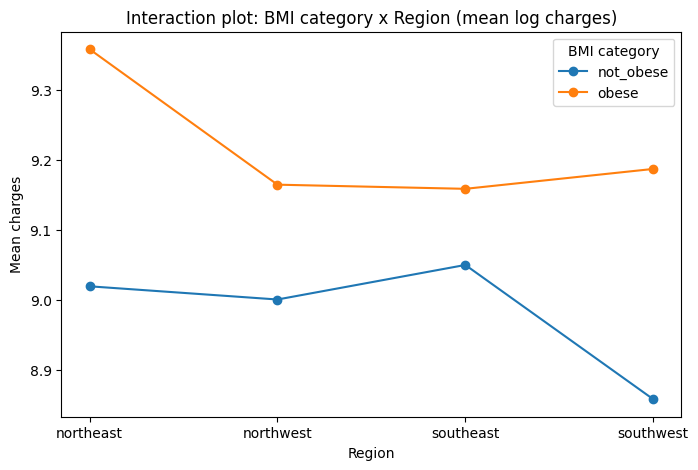

In [31]:
# Interaction plot (mean charges)
plt.figure(figsize=(8,5))
means = df.groupby(['bmi_cat','region'])['log_charges'].mean().unstack()
for bmi in means.index:
    plt.plot(means.columns, means.loc[bmi], marker='o', label=str(bmi))
plt.xlabel('Region'); plt.ylabel('Mean charges'); plt.title('Interaction plot: BMI category x Region (mean log charges)')
plt.legend(title='BMI category')
plt.show()

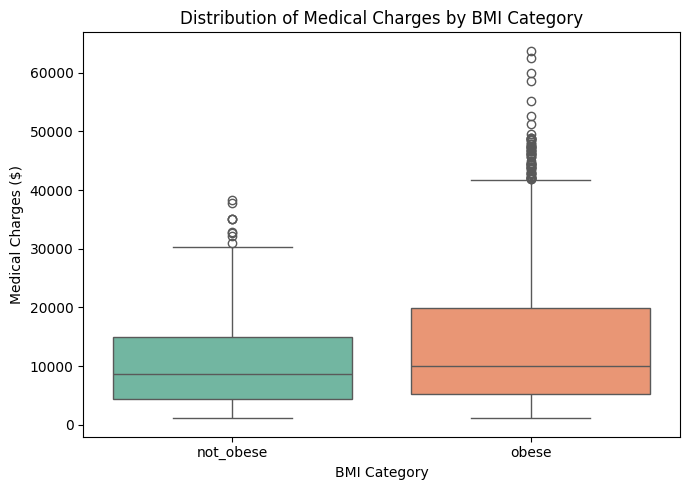

In [32]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x="bmi_cat", y="charges",
    palette="Set2"
)
plt.xlabel("BMI Category")
plt.ylabel("Medical Charges ($)")
plt.title("Distribution of Medical Charges by BMI Category")
plt.tight_layout()
plt.show()


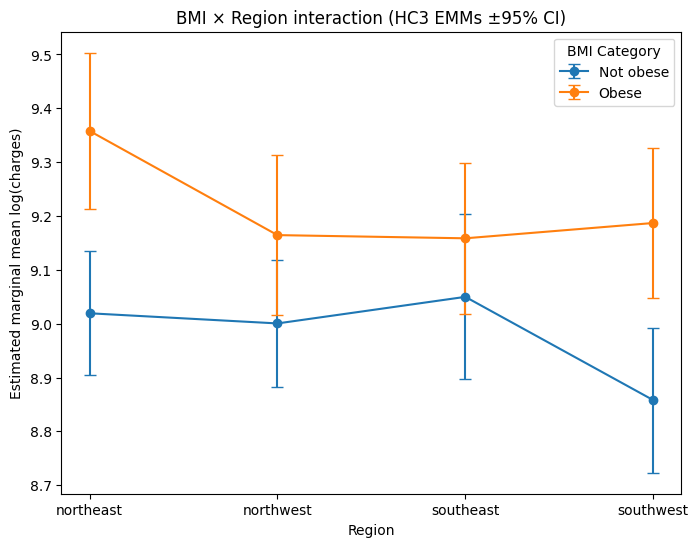

In [33]:
import matplotlib.pyplot as plt
from scipy import stats

def _emm_ci(est, se, df_resid, alpha=0.05):
    """Compute (1-alpha)% CI for an estimated marginal mean."""
    tval = stats.t.ppf(1 - alpha/2, df_resid)
    return est - tval * se, est + tval * se


cell_emms = []
for (bmi, reg) in _observed_cells(df, "bmi_cat", "region"):
    new_df = pd.DataFrame([{"bmi_cat": bmi, "region": reg}])
    X = _design_row_from_levels(model_hc3, new_df)
    est, se = _emm_point_se(model_hc3, X)
    ci_low, ci_up = _emm_ci(est, se, model_hc3.df_resid)
    cell_emms.append((bmi, reg, est, se, ci_low, ci_up))
cell_emms = pd.DataFrame(cell_emms, columns=["BMI","Region","EMM","SE","CI_lower","CI_upper"])

plt.figure(figsize=(8,6))
for bmi in cell_emms["BMI"].unique():
    subset = cell_emms[cell_emms["BMI"]==bmi]
    plt.errorbar(
        subset["Region"], subset["EMM"],
        yerr=[subset["EMM"]-subset["CI_lower"], subset["CI_upper"]-subset["EMM"]],
        fmt="o-", capsize=4, label=str(bmi)
    )
plt.xlabel("Region")
plt.ylabel("Estimated marginal mean log(charges)")
plt.title("BMI × Region interaction (HC3 EMMs ±95% CI)")
plt.legend(title="BMI Category", labels=["Not obese","Obese"])
plt.show()


### 3. 2^k factorial design

In [34]:
# === 2^3 FACTORIAL: smoker × sex × children (with HC3 Robust ANOVA + EMM post-hoc) ===
import numpy as np
import pandas as pd
from itertools import combinations
from patsy import build_design_matrices
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests

# -------------------------------------------------
# 0) Prepare factors and DV
# -------------------------------------------------
df = pd.read_csv("data2/insurance.csv")

df.drop_duplicates(inplace=True)
df.duplicated().value_counts()
# children -> binary factor: 0 vs >=1
if "children_bin" not in df.columns:
    df["children_bin"] = np.where(df["children"].astype(int) > 0, "Yes", "No")
bins = [-np.inf, 30, np.inf]
labels = ["not_obese", "obese"]
df["bmi_cat"] = pd.cut(df["bmi"], bins=bins, labels=labels, right=True)

# categories (set explicit order for readability)
df["smoker"] = df["smoker"].astype("category")
df["sex"] = df["sex"].astype("category")
df["children_bin"] = pd.Categorical(df["children_bin"], categories=["No","Yes"], ordered=True)
df["bmi_cat"] = df["bmi_cat"].astype("category")

# log DV
if "log_charges" not in df.columns:
    df["log_charges"] = np.log(df["charges"].astype(float))

# Keep only complete cases for these vars
keep_cols = ["smoker","sex","children_bin","charges","log_charges"]
df_fac = df.dropna(subset=keep_cols).copy()


=== Classical 2^4 ANOVA (Type II) ===
                                                 sum_sq      df            F  \
C(smoker)                                    499.508250     1.0  1182.141785   
C(sex)                                         3.442681     1.0     8.147488   
C(children_bin)                               24.142300     1.0    57.135435   
C(bmi_cat)                                    16.980838     1.0    40.187041   
C(smoker):C(sex)                               0.785397     1.0     1.858729   
C(smoker):C(children_bin)                      4.273413     1.0    10.113508   
C(sex):C(children_bin)                         0.021989     1.0     0.052039   
C(smoker):C(bmi_cat)                          17.610359     1.0    41.676871   
C(sex):C(bmi_cat)                              0.120990     1.0     0.286337   
C(children_bin):C(bmi_cat)                     0.004698     1.0     0.011117   
C(smoker):C(sex):C(children_bin)               0.019987     1.0     0.047302   
C

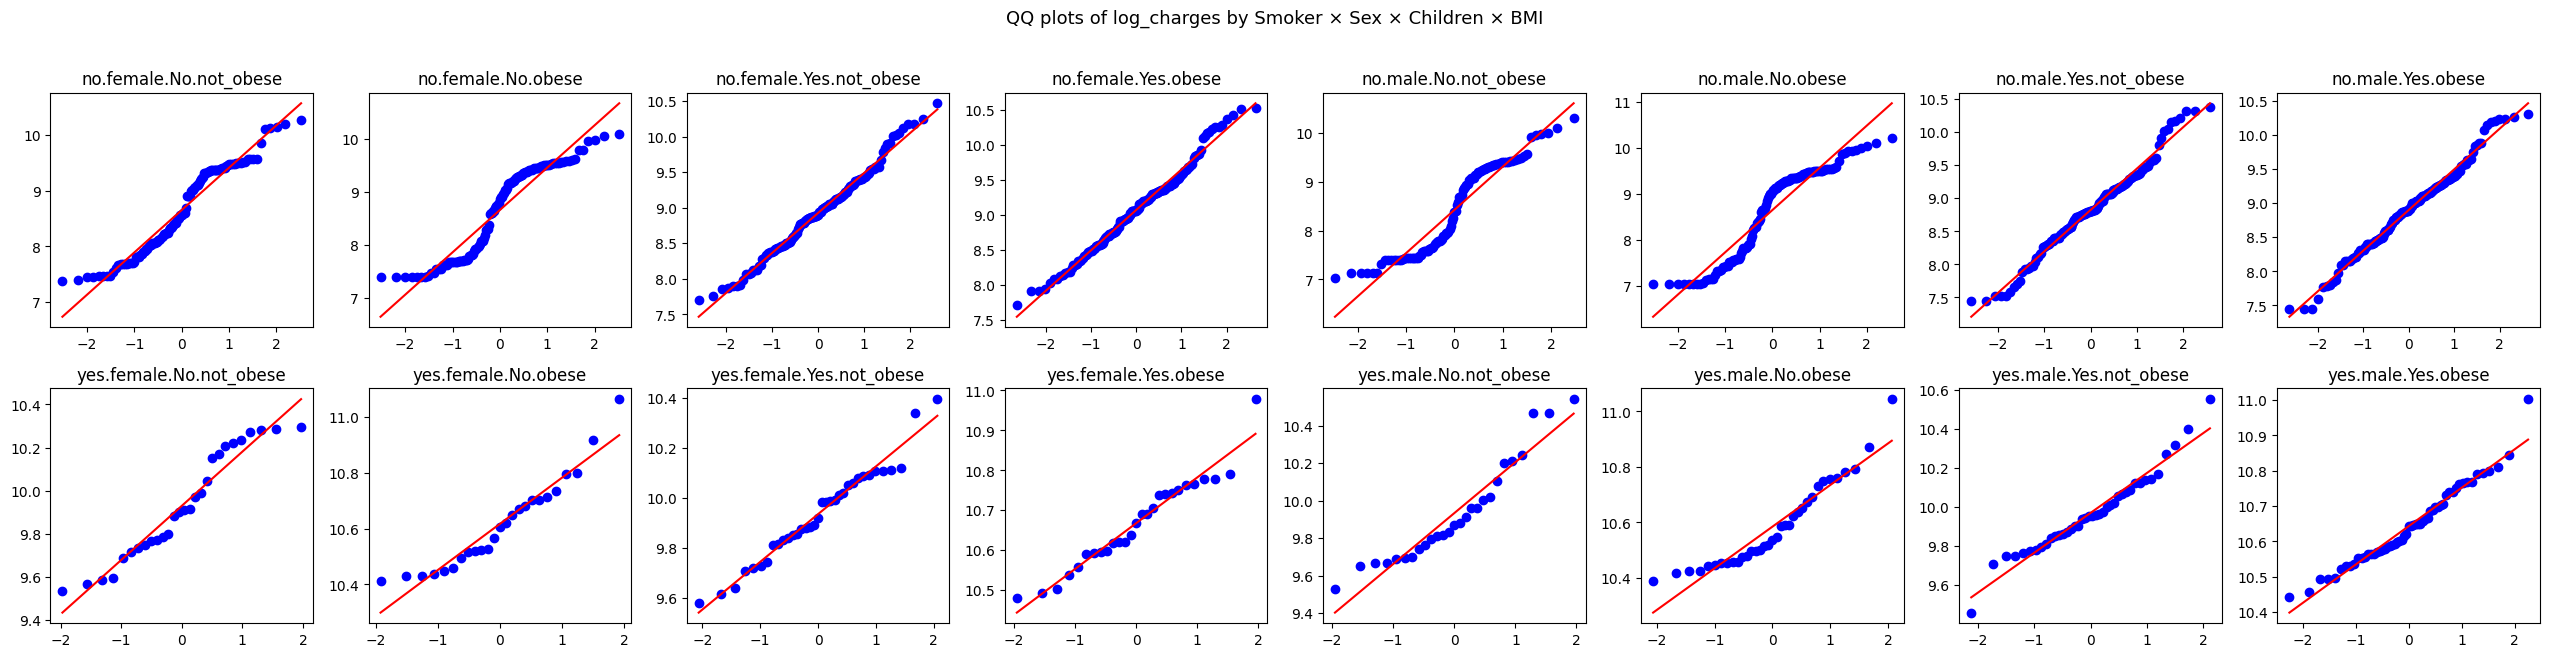

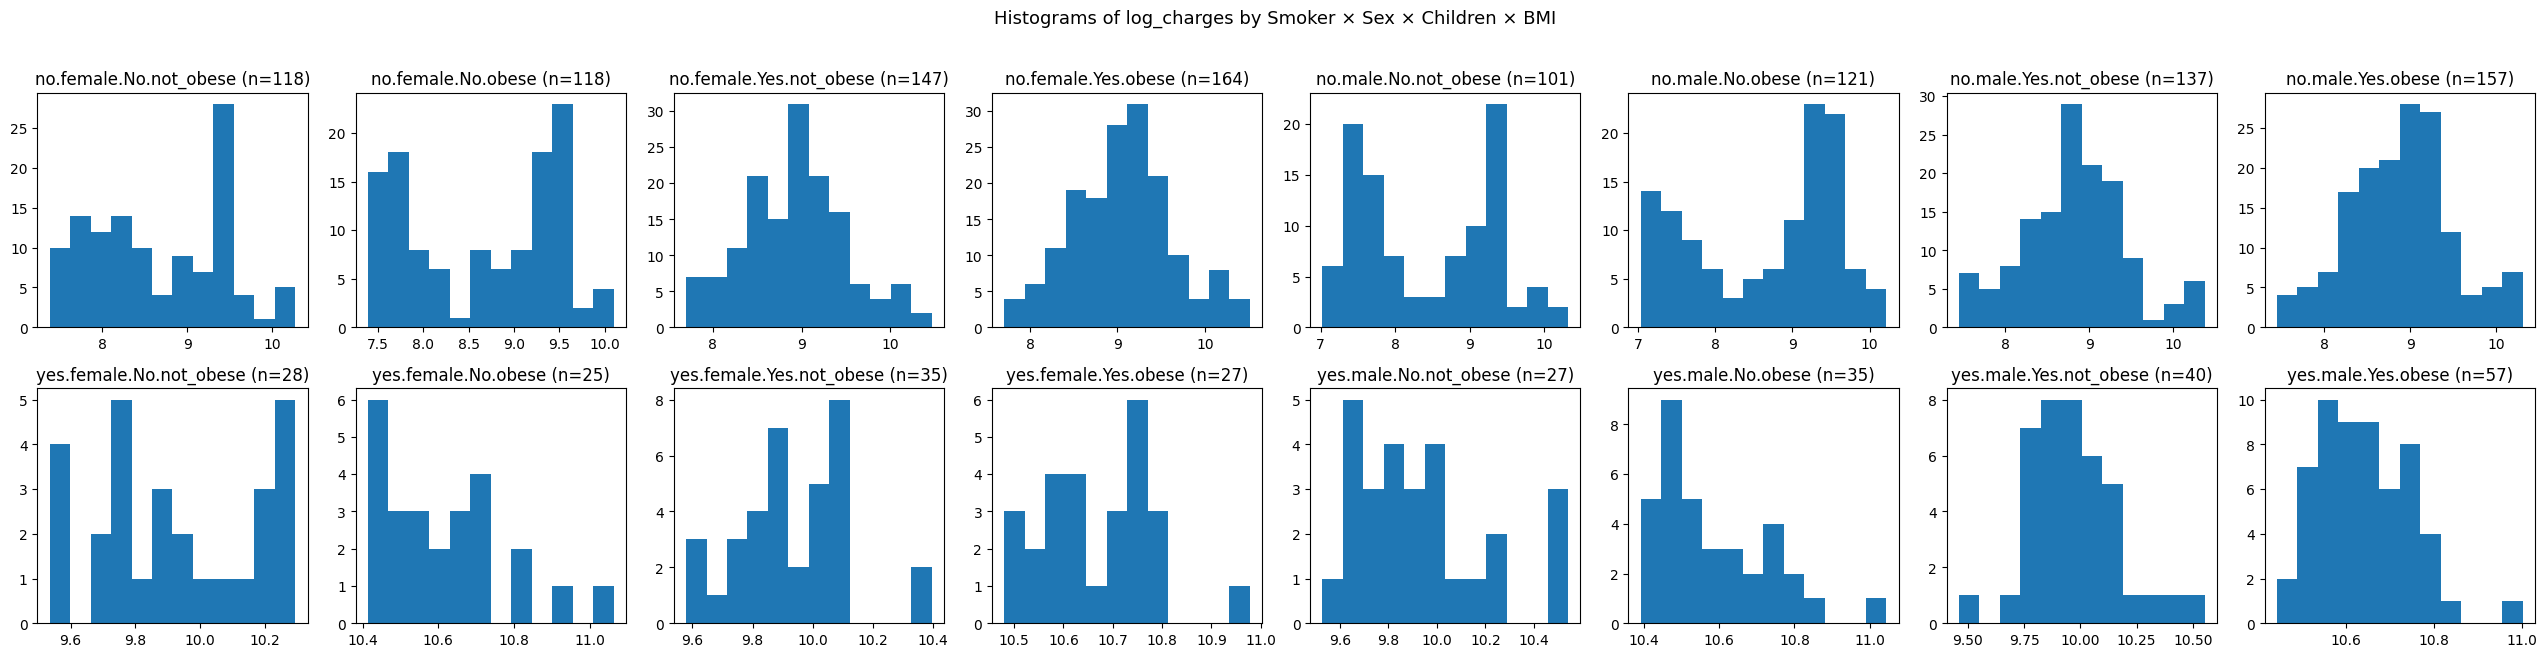

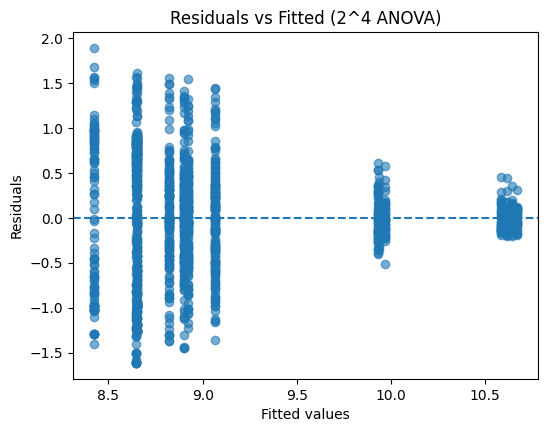

In [35]:
from itertools import product

DV = "log_charges"

# ----------------------------
# 1) Classical 2^4 ANOVA
# ----------------------------
formula = f"{DV} ~ C(smoker)*C(sex)*C(children_bin)*C(bmi_cat)"
model_classic = ols(formula, data=df).fit()
anova_classic = anova_lm(model_classic, typ=2)
print("\n=== Classical 2^4 ANOVA (Type II) ===")
print(anova_classic)

# ----------------------------
# 2) Assumption checks
# ----------------------------
levels_smoker   = df["smoker"].cat.categories
levels_sex      = df["sex"].cat.categories
levels_children = df["children_bin"].cat.categories
levels_bmi      = df["bmi_cat"].cat.categories

# QQ plots per cell
n_rows = len(levels_smoker)
n_cols = len(levels_sex) * len(levels_children) * len(levels_bmi)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 3.2*n_rows))
fig.suptitle(f"QQ plots of {DV} by Smoker × Sex × Children × BMI", y=1.02, fontsize=13)

for i, smk in enumerate(levels_smoker):
    for j, (sx, ch, bm) in enumerate(product(levels_sex, levels_children, levels_bmi)):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        cell_data = df[(df["smoker"] == smk) & (df["sex"] == sx) & (df["children_bin"] == ch) & (df["bmi_cat"] == bm)][DV]
        if len(cell_data) >= 3:
            stats.probplot(cell_data, dist="norm", plot=ax)
            ax.set_title(f"{smk}.{sx}.{ch}.{bm}")
        else:
            ax.text(0.5, 0.5, f"{smk}.{sx}.{ch}.{bm}\n(n={len(cell_data)})", ha="center", va="center")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Histograms per cell
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 3.2*n_rows))
fig.suptitle(f"Histograms of {DV} by Smoker × Sex × Children × BMI", y=1.02, fontsize=13)

for i, smk in enumerate(levels_smoker):
    for j, (sx, ch, bm) in enumerate(product(levels_sex, levels_children, levels_bmi)):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        cell_data = df[(df["smoker"] == smk) & (df["sex"] == sx) & (df["children_bin"] == ch) & (df["bmi_cat"] == bm)][DV]
        if len(cell_data) > 0:
            ax.hist(cell_data, bins=12)
            ax.set_title(f"{smk}.{sx}.{ch}.{bm} (n={len(cell_data)})")
        else:
            ax.text(0.5, 0.5, f"{smk}.{sx}.{ch}.{bm}\n(n=0)", ha="center", va="center")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Residuals vs fitted (from classical model)
fitted = model_classic.fittedvalues
resid = model_classic.resid

plt.figure(figsize=(6, 4.5))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (2^4 ANOVA)")
plt.show()

In [36]:
# -------------------------------------------------
# 3) HC3 Robust ANOVA (Type II)
# -------------------------------------------------
model_hc3 = ols(formula, data=df).fit(cov_type="HC3")
anova_hc3 = anova_lm(model_hc3, typ=2, robust="hc3")
print("\n=== 2^4 Factorial ANOVA (HC3 Robust, Type II) ===")
print(anova_hc3)


# -------------------------------------------------
# 4) Helper functions (emmeans-style)
# -------------------------------------------------
def _design_row_from_levels(model, new_df):
    """Build a design row using the model's design_info to keep coding identical."""
    design_info = model.model.data.design_info
    X_new = build_design_matrices([design_info], new_df)[0]
    return np.asarray(X_new)

def _emm_point_se(model, Xbar):
    """Estimate and SE for a given mean design row (HC3 covariance)."""
    params = model.params.values
    cov = model.cov_params().values
    est = (Xbar @ params).item()
    se = np.sqrt((Xbar @ cov @ Xbar.T).item())
    return est, se

def _contrast_test(model, x1, x2):
    """Two-EMM contrast (x1 - x2) with HC3 SE and t-test."""
    delta = (x1 - x2).reshape(1, -1)
    params = model.params.values
    cov = model.cov_params().values
    diff = (delta @ params).item()
    se = np.sqrt((delta @ cov @ delta.T).item())
    tval = diff / se if se > 0 else np.nan
    pval = 2 * (1 - stats.t.cdf(abs(tval), model.df_resid))
    return diff, se, tval, pval

def _pairwise_from_Xbars(model, Xbars):
    """All pairwise contrasts among dict of name->Xbar rows."""
    keys = list(Xbars.keys())
    rows = []
    for a, b in combinations(keys, 2):
        x1, x2 = Xbars[a], Xbars[b]
        diff, se, tval, pval = _contrast_test(model, x1, x2)
        rows.append([a, b, diff, se, tval, pval])
    out = pd.DataFrame(rows, columns=["Group1","Group2","Diff_log","SE_log","t","p"])
    if len(out):
        out["p_adj"] = multipletests(out["p"].values, method="holm")[1]
        out["ratio"] = np.exp(out["Diff_log"])
        out["pct_change"] = (out["ratio"] - 1.0) * 100.0
        out = out[out["p_adj"] < 0.05]  # keep only significant
    return out.sort_values("p_adj").reset_index(drop=True)

def _average_over_levels(model, fixed_map, avg_over):
    """Equal-weight mean design row for fixed_map, averaging equally over avg_over."""
    grids = [df[f].cat.categories for f in avg_over]
    combos = [dict(zip(avg_over, vals))
              for vals in np.array(np.meshgrid(*grids, indexing="ij")).reshape(len(avg_over), -1).T]
    rows = []
    for combo in combos:
        new_levels = {**fixed_map, **combo}
        new_df = pd.DataFrame([new_levels])
        X = _design_row_from_levels(model, new_df)
        rows.append(X)
    return np.mean(np.vstack(rows), axis=0, keepdims=True)

def _emm_for_factors(model, factors):
    """
    Compute EMMs for a set of factors.
    If len(factors)==1 → main effect
    If len(factors)==2 → 2-way interaction
    etc.
    """
    grids = [df[f].cat.categories for f in factors]
    combos = [dict(zip(factors, vals))
              for vals in np.array(np.meshgrid(*grids, indexing="ij")).reshape(len(factors), -1).T]

    emms, Xbars = {}, {}
    for combo in combos:
        label = "|".join([f"{k}={v}" for k,v in combo.items()])
        # average over other factors not in this effect
        avg_over = [f for f in df.columns if f in ["smoker","sex","children_bin","bmi_cat"] and f not in factors]
        Xbar = _average_over_levels(model, combo, avg_over) if avg_over else _design_row_from_levels(model, pd.DataFrame([combo]))
        est, se = _emm_point_se(model, Xbar)
        emms[label] = (est, se)
        Xbars[label] = Xbar
    return emms, Xbars

def _emms_table(emms_dict, id_name):
    tbl = pd.DataFrame([(k, v[0], v[1]) for k, v in emms_dict.items()],
                       columns=[id_name, "EMM_log", "SE_log"])
    tbl["EMM_charge"] = np.exp(tbl["EMM_log"])
    return tbl


# -------------------------------------------------
# 5) Adaptive post-hoc: only run if ANOVA sig
# -------------------------------------------------
def posthoc_hc3_factorial(model, anova_table, alpha=0.05):
    factors = ["smoker", "sex", "children_bin", "bmi_cat"]

    for k in anova_table.index:
        if "Residual" in k:
            continue  # skip residual row
    
        pval = anova_table.loc[k, "PR(>F)"]
        if pval >= alpha:
            continue  # skip non-sig effects
    
        terms = k.replace("C(","").replace(")","").split(":")
        terms = [t.split("[")[0] for t in terms if t in df.columns]  # keep only real factors

        print(f"\n=== Significant effect: {k} (p={pval:.4g}) ===")

        emms, Xbars = _emm_for_factors(model, terms)
        emmt = _emms_table(emms, id_name="×".join(terms))
        print("\nEstimated Marginal Means:")
        print(emmt.sort_values(emmt.columns[0]))

        pairs = _pairwise_from_Xbars(model, Xbars)
        if len(pairs):
            print("\nSignificant Pairwise Contrasts (HC3, Holm-adjusted):")
            print(pairs)


# -------------------------------------------------
# 6) Run adaptive EMM post-hoc (HC3)
# -------------------------------------------------
posthoc_hc3_factorial(model_hc3, anova_hc3)



=== 2^4 Factorial ANOVA (HC3 Robust, Type II) ===
                                                  sum_sq      df            F  \
C(smoker)                                    1752.832695     1.0  4148.273367   
C(sex)                                          1.633014     1.0     3.864709   
C(children_bin)                                10.264803     1.0    24.292797   
C(bmi_cat)                                    346.313121     1.0   819.588488   
C(smoker):C(sex)                                3.178277     1.0     7.521746   
C(smoker):C(children_bin)                      12.936423     1.0    30.615483   
C(sex):C(children_bin)                          0.016552     1.0     0.039173   
C(smoker):C(bmi_cat)                           66.324584     1.0   156.964498   
C(sex):C(bmi_cat)                               0.398170     1.0     0.942313   
C(children_bin):C(bmi_cat)                      0.202763     1.0     0.479861   
C(smoker):C(sex):C(children_bin)                0.102560  


=== Significant effect: C(smoker) (p=0) ===

Estimated Marginal Means:
       smoker    EMM_log    SE_log    EMM_charge
0   smoker=no   8.760703  0.023759   6378.593554
1  smoker=yes  10.285008  0.012318  29290.184504

Significant Pairwise Contrasts (HC3, Holm-adjusted):
      Group1      Group2  Diff_log    SE_log         t    p  p_adj     ratio  \
0  smoker=no  smoker=yes -1.524305  0.026762 -56.95719  0.0    0.0  0.217772   

   pct_change  
0  -78.222761  

=== Significant effect: C(sex) (p=0.04952) ===

Estimated Marginal Means:
          sex   EMM_log    SE_log    EMM_charge
0  sex=female  9.555529  0.017703  14122.567319
1    sex=male  9.490181  0.020070  13229.193944

Significant Pairwise Contrasts (HC3, Holm-adjusted):
       Group1    Group2  Diff_log    SE_log         t         p     p_adj  \
0  sex=female  sex=male  0.065348  0.026762  2.441794  0.014745  0.014745   

     ratio  pct_change  
0  1.06753    6.753045  

=== Significant effect: C(children_bin) (p=9.323e-07) =

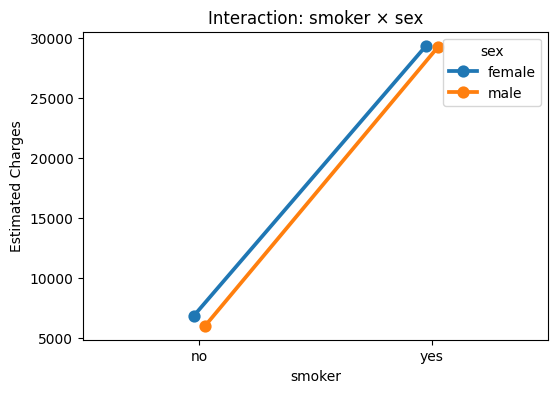


=== Significant effect: C(smoker):C(children_bin) (p=3.789e-08) ===

Estimated Marginal Means:
           smoker|children_bin    EMM_log    SE_log    EMM_charge
0    smoker=no|children_bin=No   8.594352  0.040953   5401.065367
1   smoker=no|children_bin=Yes   8.927054  0.024101   7533.042642
2   smoker=yes|children_bin=No  10.266034  0.020804  28739.679882
3  smoker=yes|children_bin=Yes  10.303981  0.013196  29851.233966

Significant Pairwise Contrasts (HC3, Holm-adjusted):
                       Group1                       Group2  Diff_log  \
0   smoker=no|children_bin=No   smoker=yes|children_bin=No -1.671683   
1   smoker=no|children_bin=No  smoker=yes|children_bin=Yes -1.709630   
2  smoker=no|children_bin=Yes   smoker=yes|children_bin=No -1.338980   
3  smoker=no|children_bin=Yes  smoker=yes|children_bin=Yes -1.376927   
4   smoker=no|children_bin=No   smoker=no|children_bin=Yes -0.332703   

     SE_log          t             p         p_adj     ratio  pct_change  
0  0.045934 

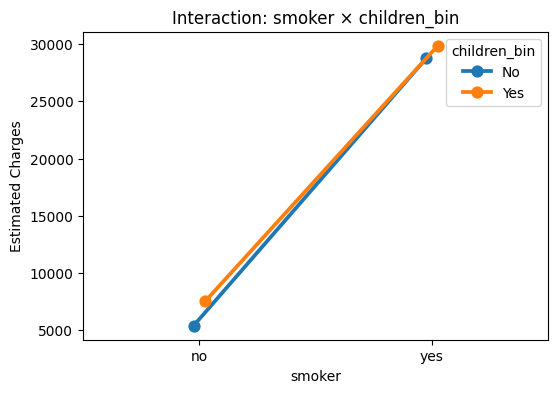


=== Significant effect: C(smoker):C(bmi_cat) (p=4.158e-34) ===

Estimated Marginal Means:
                 smoker|bmi_cat    EMM_log    SE_log    EMM_charge
0   smoker=no|bmi_cat=not_obese   8.705105  0.033941   6033.633633
1       smoker=no|bmi_cat=obese   8.816301  0.033256   6743.275810
2  smoker=yes|bmi_cat=not_obese   9.941954  0.021214  20784.321714
3      smoker=yes|bmi_cat=obese  10.628061  0.012526  41277.022174

Significant Pairwise Contrasts (HC3, Holm-adjusted):
                         Group1                        Group2  Diff_log  \
0   smoker=no|bmi_cat=not_obese  smoker=yes|bmi_cat=not_obese -1.236850   
1   smoker=no|bmi_cat=not_obese      smoker=yes|bmi_cat=obese -1.922957   
2       smoker=no|bmi_cat=obese  smoker=yes|bmi_cat=not_obese -1.125653   
3       smoker=no|bmi_cat=obese      smoker=yes|bmi_cat=obese -1.811760   
4  smoker=yes|bmi_cat=not_obese      smoker=yes|bmi_cat=obese -0.686107   
5   smoker=no|bmi_cat=not_obese       smoker=no|bmi_cat=obese -0.11119

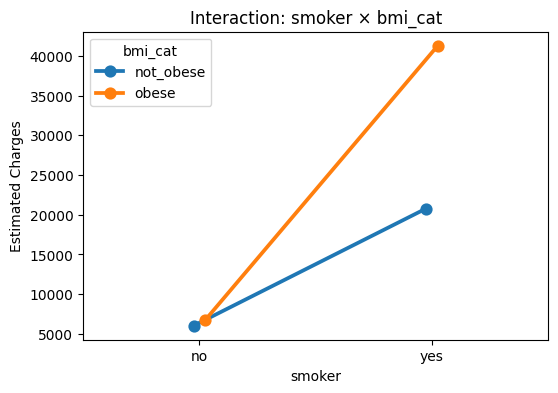

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emm_interaction(emmt, factors, id_name):
    """
    Draw interaction plot from EMM table for 2-way or higher factors.
    """
    # Split factor labels into separate columns
    emmt[factors] = emmt[id_name].str.split(r"\|", expand=True).apply(
        lambda col: col.str.split("=", expand=True)[1]
    )

    if len(factors) == 2:  # two-way interaction
        f1, f2 = factors
        plt.figure(figsize=(6, 4))

        # Define custom error function using SE_log
        def se_as_error(values):
            # map to matching SEs from dataframe
            idx = values.index
            return emmt.loc[idx, "SE_log"].to_numpy()

        sns.pointplot(
            data=emmt, x=f1, y="EMM_charge", hue=f2,
            dodge=True, markers="o", capsize=.1, errwidth=1,
            errorbar=se_as_error
        )

        plt.title(f"Interaction: {f1} × {f2}")
        plt.ylabel("Estimated Charges")
        plt.xlabel(f1)
        plt.legend(title=f2)
        plt.show()

    elif len(factors) > 2:  # three-way or higher
        f1, f2, *rest = factors

        def se_as_error(values):
            idx = values.index
            return emmt.loc[idx, "SE_log"].to_numpy()

        g = sns.catplot(
            data=emmt, x=f1, y="EMM_charge", hue=f2,
            col=rest[0] if len(rest) else None,
            kind="point", dodge=True, markers="o", capsize=.1, errwidth=1,
            errorbar=se_as_error
        )
        g.fig.subplots_adjust(top=0.8)
        g.fig.suptitle(f"Interaction: {' × '.join(factors)}")
        plt.show()


def posthoc_hc3_factorial_with_plots(model, anova_table, alpha=0.05):
    """
    Adaptive posthoc with automatic interaction plots for significant effects.
    """
    for k in anova_table.index:
        if "Residual" in k:
            continue

        pval = anova_table.loc[k, "PR(>F)"]
        if pval >= alpha:
            continue

        # Extract factor names from term label
        terms = k.replace("C(","").replace(")","").split(":")
        terms = [t.split("[")[0] for t in terms if t in df.columns]

        print(f"\n=== Significant effect: {k} (p={pval:.4g}) ===")

        emms, Xbars = _emm_for_factors(model, terms)
        emmt = _emms_table(emms, id_name="|".join(terms))
        print("\nEstimated Marginal Means:")
        print(emmt.sort_values(emmt.columns[0]))

        pairs = _pairwise_from_Xbars(model, Xbars)
        if len(pairs):
            print("\nSignificant Pairwise Contrasts (HC3, Holm-adjusted):")
            print(pairs)

        # Automatically plot if it's an interaction (≥ 2 factors)
        if len(terms) >= 2:
            plot_emm_interaction(emmt, terms, id_name="|".join(terms))


# --- Run it ---
posthoc_hc3_factorial_with_plots(model_hc3, anova_hc3)
